# Phenotyping Censored Survival Data
<hr>

Author: ***Willa Potosnak***  &lt;wpotosna@andrew.cmu.edu&gt;

<div style=" float: right;">
<img align="right" src="https://ndownloader.figshare.com/files/34052981" width="25%"/>
<img align="right" src="https://www.cs.cmu.edu/~chiragn/auton_logo.png" width="25%"/>
</div>

# Contents


### 1. [Introduction](#intro) 
####    &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;  1.1 [The SUPPORT Dataset](#support)
####    &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;  1.2 [Preprocessing the Data](#preprocess)

### 2. [Intersectional Phenotyping](#interpheno) 
####    &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   2.1 [Fitting the Intersectional Phenotyper](#fitinter)
####    &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   2.2 [Plotting Survival Curves](#plotpheno)
       
### 3. [Unsupervised Phenotyping](#clusterpheno)
####    &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   3.1 [Fitting the Clustering Phenotyper](#fitcluster)
####    &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   3.2 [Plotting Survival Curves](#clusterplot)
####    &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   3.3 [Evaluating Phenotype Purity](#clusterphenopur)

### 4. [Supervised Phenotyping with Deep Cox Mixtures (DCM)](#DCM)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   4.1 [Fitting the DCM Model](#fitDCM)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   4.2 [Inferring Latent Phenotypes](#latentz)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   4.3 [Plotting Survival Curves](#plotlatent)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   4.4 [Evaluating Phenotype Purity](#superphenopur)

### 5. [Counterfactual Phenotyping](#counterpheno)
<hr>


<a id="intro"></a>

## 1. Introduction

`auton-survival` offers utilities to phenotype, or group, samples for use in assessing differential survival probabilities across groups. Phenotyping can aid clinical decision makers by offering insight into groups of patients for which differential survival probabilities exist. This insight can influence clinical practices applied to these groups.
   * <b>Intersectional Phenotyping</b> 
       - Identify phenotypes of samples from all possible combinations of user-specified categorical and numerical features.
   * <b>Unsupervised Phenotyping</b>
       - Identify phenotypes that group samples based on similarity in the feature space.
   * <b>Supervised Phenotyping</b>
       - Identify latent groups of individuals with similar survival outcomes. 
   * <b>Counterfactual Phenotyping</b>
       - Identify latent phenotypes that demonstrate heterogneous effects to an intervention. 

<a id="support"></a>

### 1.1. The SUPPORT Dataset

*For the original datasource, please refer to the following [website](https://biostat.app.vumc.org/wiki/Main/SupportDesc).*

Data features, $\mathbf{x}$, are stored in a pandas dataframe with rows corresponding to individual samples and columns as covariates. Data outcomes consists of 'time', $\mathbf{t}$, and 'event', $\mathbf{e}$, that correspond to the time to event and the censoring indicator, respectively. 

In [ ]:
# Suppress all warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import sys
sys.path.append('../')

from auton_survival.datasets import load_dataset

<a id="preprocess"></a>
### 1.2. Preprocessing the Data

In [2]:
# Load the SUPPORT dataset
outcomes, features = load_dataset(dataset='SUPPORT')

# Identify categorical (cat_feats) and continuous (num_feats) features
cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp', 
             'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 
             'glucose', 'bun', 'urine', 'adlp', 'adls']

# Let's take a look at the features
display(features.head(5))

# Let's take a look at the outcomes
display(outcomes.head(5))

,sex,dzgroup,dzclass,income,race,ca,age,num.co,meanbp,wblc,...,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls
0,male,Lung Cancer,Cancer,$11-$25k,other,metastatic,62.84998,0,97.0,6.000000,...,1.799805,0.199982,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0
1,female,Cirrhosis,COPD/CHF/Cirrhosis,$11-$25k,white,no,60.33899,2,43.0,17.097656,...,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0
2,female,Cirrhosis,COPD/CHF/Cirrhosis,under $11k,white,no,52.74698,2,70.0,8.500000,...,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN,1.0,0.0
3,female,Lung Cancer,Cancer,under $11k,white,metastatic,42.38498,2,75.0,9.099609,...,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN,0.0,0.0
4,female,ARF/MOSF w/Sepsis,ARF/MOSF,NaN,white,no,79.88495,1,59.0,13.500000,...,NaN,NaN,0.799927,143.0,7.509766,NaN,NaN,NaN,NaN,2.0


,event,time
0,0,2029
1,1,4
2,1,47
3,1,133
4,0,2029


Here we perform imputation and scaling on the entire dataset but in practice we recommend that preprocessing tools be fitted solely to training data.

In [3]:
# ====================================================================================
# Fixed here: Preprocessing to ensure numeric data for PyTorch models
# ====================================================================================
from auton_survival.preprocessing import Preprocessor
import pandas as pd
import numpy as np

# Fixed: Changed cat_feat_strat from 'ignore' to 'mode' to properly encode categorical features
preprocessor = Preprocessor(cat_feat_strat='mode', num_feat_strat='mean') 
x = preprocessor.fit_transform(features, cat_feats=cat_feats, num_feats=num_feats,
                                one_hot=True, fill_value=-1)

# Fixed: Convert any object columns to numeric for PyTorch compatibility
for col in x.columns:
    if x[col].dtype == 'object':
        x[col] = pd.to_numeric(x[col], errors='coerce')

# Fixed: Use float64 to match PyTorch's default precision (avoids dtype mismatch)
x = x.fillna(0).astype('float64')

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
x_tr, x_te, y_tr, y_te = train_test_split(x, outcomes, test_size=0.2, random_state=1) 

print(f'Number of training data points: {len(x_tr)}')
print(f'Number of test data points: {len(x_te)}')

Number of training data points: 7284
Number of test data points: 1821


<a id="interpheno"></a>
## 2. Intersectional Phenotyping

The intersectional Phenotyper performs an exhaustive cartesian product on the user-specified set of categorical and numerical variables to obtain the phenotypes. Numeric variables are binned based on user-specified quantiles.

<a id="fitinter"></a>
### 2.1. Fitting the Intersectional Phenotyper

Here we fit the phenotyper on the entire dataset but in practice we recommend that the phenotyper be fitted solely to training data.

In [5]:
from auton_survival.phenotyping import IntersectionalPhenotyper

# We create two bins based on the following quantiles of age groups
quantiles = (0, .5, 1.0)

# 'ca' is cancer status
phenotyper = IntersectionalPhenotyper(cat_vars=['ca'], num_vars=['age'],
                                        num_vars_quantiles=quantiles, random_seed=0)
phenotypes = phenotyper.fit_predict(features)

# Let's look at the phenotypes for each sample
phenotypes 

array(['ca:metastatic & age:(18.041, 64.857]',
       'ca:no & age:(18.041, 64.857]', 'ca:no & age:(18.041, 64.857]',
       ..., 'ca:no & age:(64.857, 101.848]',
       'ca:yes & age:(18.041, 64.857]', 'ca:no & age:(64.857, 101.848]'],
      dtype='<U37')

<a id="plotpheno"></a>
### 2.2. Plotting Survival Curves

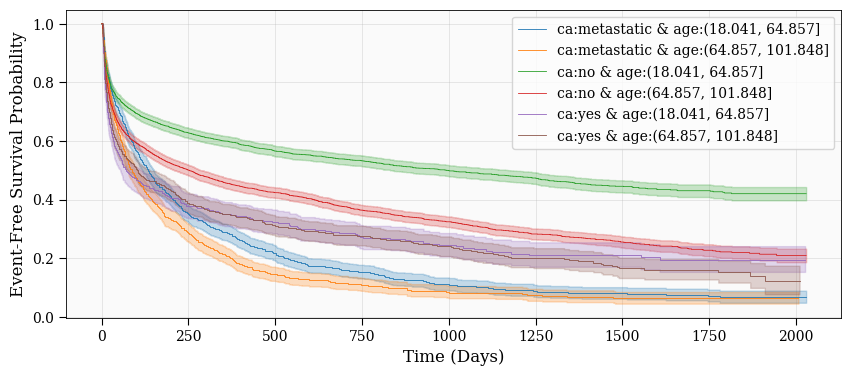

In [6]:
from auton_survival import reporting
import matplotlib.pyplot as plt

# Estimate the probability of event-free survival for phenotypes using the Kaplan Meier estimator.
reporting.plot_kaplanmeier(outcomes, phenotypes)

plt.xlabel('Time (Days)')
plt.ylabel('Event-Free Survival Probability')
plt.legend(loc="upper right")
plt.show()

As you can see, patients ages 18 to 64 without cancer have the highest survival rates. Alternatively, patients ages 64 to 101 with metastatic cancer have the lowest survival rates.

<a id="clusterpheno"></a>
## 3. Unsupervised Phenotyping

Dimensionality reduction of the input covariates, $\mathbf{x}$, is performed followed by clustering. Learned clusters are considered phenotypes and used to group samples based on similarity in the covariate space. The estimated probability of sample cluster association is computed as the sample distance to a cluster center normalized by the sum of distances to other clusters.

\begin{align}
\mathbf{P}(Z=k | X=\mathbf{x}_i) = \frac{\mathbf{d}(x_i, x_c)}{\sum_{j=1}^{K} \mathbf{d}(x_i, x_j)}
\end{align}

Where $d_i$ is the distance to a cluster $k$ for i $\in$ \{1, 2, ..., $n$\} where $i$ $\not=$ $c$.

<a id="fitcluster"></a>
### 3.1. Fitting the Clustering Phenotyper

In [7]:
from auton_survival.phenotyping import ClusteringPhenotyper

# Perform dimensionality reduction using Principal Component Analysis (PCA)
dim_red_method = 'pca' 
# We use a Gaussian Mixture Model with a diagonal covariance matrix
clustering_method = 'gmm'
n_components = 8 
n_clusters = 2 # Number of underlying phenotypes

# Initialize and fit the clustering phenotyper
phenotyper = ClusteringPhenotyper(clustering_method=clustering_method, 
                                              dim_red_method=dim_red_method, 
                                              n_components=n_components, 
                                              n_clusters=n_clusters)
phenotypes = phenotyper.fit_predict(x_tr)

# Let's look at the phenotypes
phenotypes

Fitting the following Dimensionality Reduction Model:
 PCA(n_components=8, random_state=0)
Fitting the following Clustering Model:
 GaussianMixture(covariance_type='diag', n_components=3, random_state=0)


array([1, 2, 1, ..., 1, 1, 2])

<a id="clusterplot"></a>
### 3.2. Plotting Survival Curves

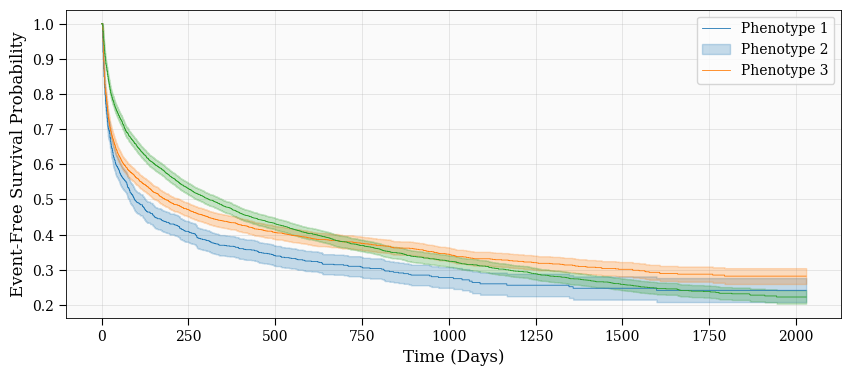

In [8]:
from auton_survival import reporting
import matplotlib.pyplot as plt

# Estimate the probability of event-free survival for phenotypes using the Kaplan Meier estimator.
reporting.plot_kaplanmeier(outcomes.loc[x_tr.index], phenotypes)

plt.xlabel('Time (Days)')
plt.ylabel('Event-Free Survival Probability')
plt.xlabel('Time (Days)')
plt.legend(['Phenotype 1', 'Phenotype 2', 'Phenotype 3'], loc="upper right")
plt.show()

Intersecting survival rates indicate that the SUPPORT dataset follows non-proportional hazards which violates assumptions of the Cox Model.

<a id="clusterphenopur"></a>
### 3.3. Evaluating Phenotype Purity

To measure a phenotyper's ability to extract subgroups with differential survival rates, we estimate the (Integrated) Brier Score by fitting a Kaplan-Meier estimator within each phenogroup and employing it to estimate the survival rate within each phenogroup. We refer to this as the *phenotyping purity.*

In [9]:
from auton_survival.metrics import phenotype_purity

# Estimate the Integrated Brier Score at event horizons of 1, 2 and 5 years.
metric = phenotype_purity(phenotypes_train=phenotypes, outcomes_train=y_tr, 
                                phenotypes_test=None, outcomes_test=None,
                                strategy='instantaneous', horizons=[365, 730, 1825], 
                                bootstrap=None)

print(f'Phenotyping purity for event horizon of 1 year: {metric[0]} | 2 years: {metric[1]} | 5 years: {metric[2]}')

Phenotyping purity for event horizon of 1 year: 0.24566771486682476 | 2 years: 0.23070467996216382 | 5 years: 0.18652445519787475


<a id="DCM"></a>
## 4. Supervised Phenotyping with Deep Cox Mixtures (DCM)

<a id="dcm"></a>

Unlike unsupervised clustering, inferring supervised phenotypes requires time-to-events and the corresponding censoring indicators along with the covariates. `auton-survival` provides utilities to perform supervised phenotyping as following training the Deep Survival Machines (DSM) and Deep Cox Mixtures (DCM) latent variable survival regression estimators. Note that DSM recovers phenotypes with similar parametric characteristics while DCM recovers phenotypes that adhere to proportional hazards.

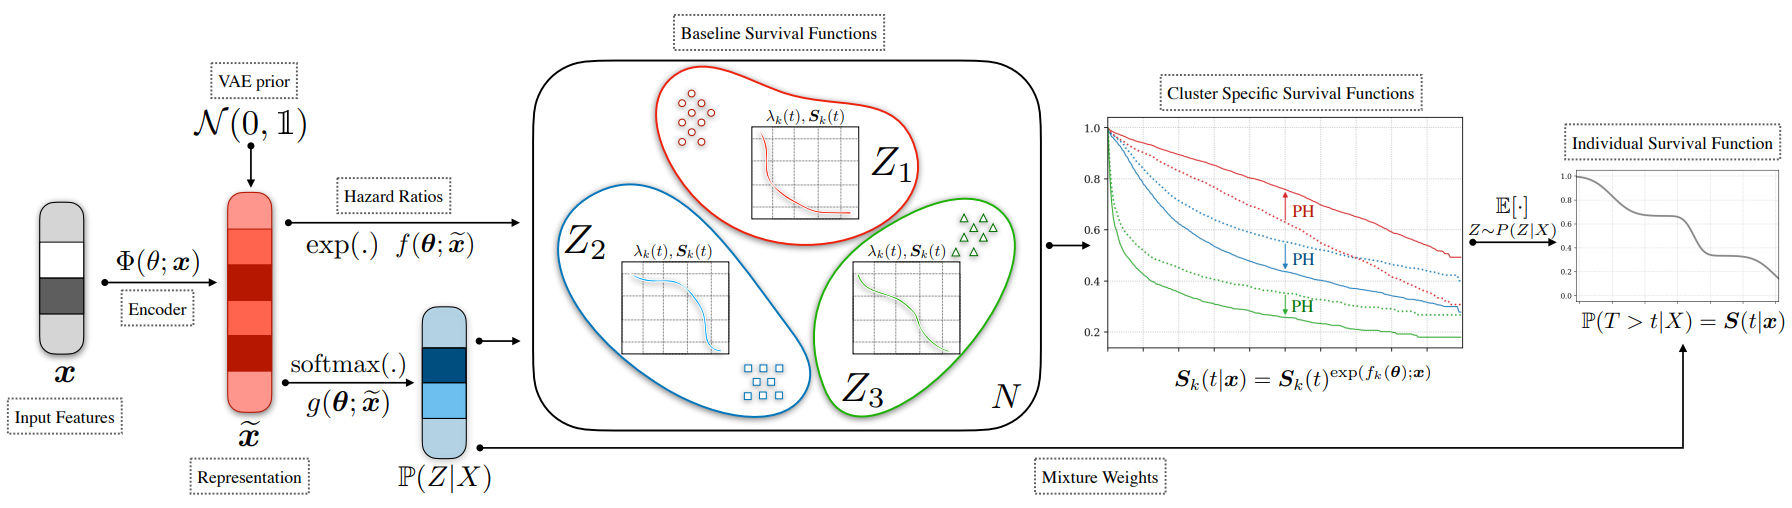

<b>Figure A:</b> DCM works by generating representation of the individual covariates, $x$, using an encoding neural network. The output representation, $xe$, then interacts with linear functions, $f$ and $g$, that determine the proportional hazards within each cluster $Z ∈ {1, 2, ...K}$ and the mixing weights $P(Z|X)$ respectively. For each cluster, baseline survival rates $Sk(t)$ are estimated non-parametrically. The final individual survival curve $S(t|x)$ is an average over the cluster specific individual survival curves weighted by the mixing probabilities $P(Z|X = x)$.


*For full details on Deep Cox Mixtures (DCM), please refer to the following paper*:

[2] [Nagpal, C., Yadlowsky, S., Rostamzadeh, N., and Heller, K. (2021c). Deep cox mixtures for survival regression. In
Machine Learning for Healthcare Conference, pages 674–708. PMLR.](https://arxiv.org/abs/2101.06536)

<a id="fitDCM"></a>
### 4.1. Fitting the DCM Model

Fit DCM model to training data. Perform hyperparameter tuning by selecting model parameters that minimize the brier score computed for the validation set.

$\textbf{Brier Score} \ (\textrm{BS})$: Defined as the Mean Squared Error (MSE) around the probabilistic prediction at a certain time horizon.
\begin{align}
\text{BS}(t) = \mathop{\mathbf{E}}_{x\sim\mathcal{D}}\big[ ||\mathbf{1}\{ T > t \} - \widehat{\mathbf{P}}(T>t|X)\big)||_{_\textbf{2}}^\textbf{2}  \big]
\end{align}

In [10]:
from auton_survival.models.dcm import DeepCoxMixtures
from sklearn.model_selection import ParameterGrid
from sksurv.metrics import brier_score

param_grid = {'k' : [3],
              'learning_rate' : [1e-3],
              'layers' : [[100]]
             }

params = ParameterGrid(param_grid)

for param in params:
    model = DeepCoxMixtures(k = param['k'],
                            layers = param['layers'],
                            random_seed=0)
    
# The fit method is called to train the model
model.fit(x_tr, y_tr.time, y_tr.event, iters = 100, learning_rate = param['learning_rate'])

 68%|██████▊   | 68/100 [00:22<00:10,  2.96it/s]


<a id="latentz"></a>
### 4.2. Inferring latent Phenotypes

The mixing probabilities $P(Z|X = x)$ estimate individual sample association to the latent phenotypes mediated by an encoder gating function 
$g(.)$. $P(Z|X = x)$ is used to weight the cluster specific individual survival curves for computing the final individual survival curve $S(t|x)$.

In [11]:
from auton_survival.models.dcm.dcm_utilities import predict_latent_z

latent_z_prob = model.predict_latent_z(x_tr.values)

# Let's look at the latent group probabilities
latent_z_prob

# Let's look at the phenotypes
phenotypes = np.argmax(latent_z_prob, axis=1)
phenotypes

array([1, 1, 1, ..., 1, 2, 1])

<a id="plotlatent"></a>
### 4.3. Plotting Survival Curves

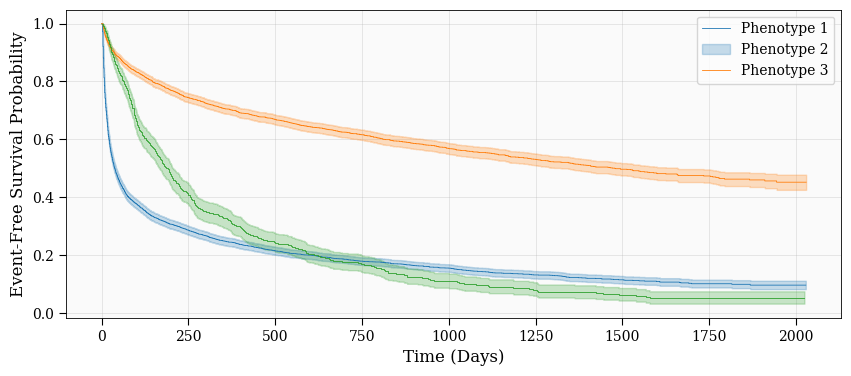

In [12]:
from auton_survival import reporting
import matplotlib.pyplot as plt

# Estimate the probability of event-free survival for phenotypes using the Kaplan Meier estimator.
reporting.plot_kaplanmeier(outcomes.loc[x_tr.index], phenotypes)

plt.xlabel('Time (Days)')
plt.ylabel('Event-Free Survival Probability')
plt.legend(['Phenotype 1', 'Phenotype 2', 'Phenotype 3'], loc="upper right")
plt.show()

Intersecting survival rates indicate that the SUPPORT dataset follows non-proportional hazards which violates assumptions of the Cox Model.

<a id="superphenopur"></a>
### 4.4. Evaluating Phenotype Purity

To measure a phenotyper's ability to extract subgroups with differential survival rates, we estimate the (Integrated) Brier Score by fitting a Kaplan-Meier estimator within each phenogroup and employing it to estimate the survival rate within each phenogroup. We refer to this as the *phenotyping purity.*

In [13]:
from auton_survival.metrics import phenotype_purity

# Estimate the Integrated Brier Score at event horizons of 1, 2 and 5 years
metric = phenotype_purity(phenotypes_train=phenotypes, outcomes_train=y_tr, 
                                phenotypes_test=None, outcomes_test=None,
                                strategy='instantaneous', horizons=[365, 730, 1825], 
                                bootstrap=None)

print(f'Phenotyping purity for event horizon of 1 year: {metric[0]} | 2 years: {metric[1]} | 5 years: {metric[2]}')

Phenotyping purity for event horizon of 1 year: 0.19824037319027946 | 2 years: 0.1847216787994317 | 5 years: 0.15162778342355063


It can be observed the phenotyping purity is lower for supervised phenotyping compared to unsupervised phenotyping. This indicates that the supervised phenotyper is able extract phenogroups with higher discriminative power in terms of the observed survival rates.

*IMPORTANT: Phenotype purity can only be compared between phenotypers that identify the same number of subgroups. This is because phenotypers that extract more subgroups than another will inherently have better phenotyping purity.*

<a id="counterpheno"></a>
## 5. Counterfactual Phenotyping

*For examples of counterfactual phenotyping with Deep Cox Mixtures with Heterogeneous Effects (CMHE) [1], please refer to the following paper and example jupyter notebook*:

[1] [Counterfactual Phenotyping with Censored Time-to-Events, arXiv preprint, C. Nagpal, M. Goswami, K. Dufendach, A. Dubrawski](https://arxiv.org/abs/2202.11089)

[Demo of CMHE on Synthetic Data.ipynb](https://github.com/autonlab/auton-survival/blob/master/examples/Demo%20of%20CMHE%20on%20Synthetic%20Data.ipynb)